# Exchange rate risk management - Longterm horizon

## 1. Literature review
Purchasing Power Parity (PPP) one of revolutionary ideas developed by Gustav Cassel in 1992 on international economics and finance . The purchasing power parity theory of Cassel is an operational theory with two propositions : 
(1) monetary factors are the most important long-run determinants of the exchange rate under a flexible exchange-rate standard; and 
(2) tariffs and hindrances to trade, transport costs, capital flows, and expectations are, random deviation aside, the remaining determinants of the exchange rate under a flexible exchange rate standard.

However, this theory remained unnoticed or were forgotten after his death until more precise interpretation of this theory was studies by academia in 1970s. Since then, this theory from Cassel was the foundation for the different PPP approach in predicting the exchange rate. 
* Absolute PPP: is the application of the law of one price to national price levels, a direct interpretation from Cassel theory. It postulates that the exchange rate between two countries’ currencies is equal to the ratio of the price level in one country to the price level in the other country.
* Relative PPP : focuses on the primary implication of absolute PPP—that the percent change in an exchange rate should be equal to the difference in inflation rates in the two countries. The equation estimates that the log of the real exchange rate according to the convention, is equal to the log of the nominal exchange rate expressed as the foreign currency price of a unit of domestic currency, and the difference of the logs of home and foreign price levels
* Hakkio relative-PPP : uses the concept of relative PPP to establish a time varying equilibrium exchange rate. According to relative PPP, one could use the inflation rates in two countries to find the implied change in the PPP equilibrium exchange rate.

Following the paper “Can A Relative Purchasing Power Parity-based Model Outperform A Random Walk In Forecasting Short-term Exchange Rates?” , the PPP models used here included absolute PPP, relative PPP, and the Hakkio-relative PPP equilibrium rate - an alternative representation of the concept of relative PPP. In this section, we will focus on the relative PPP and the Hakkio-relative PPP equilibrium rate approach for modelling and model configuration.

## 2. Data
### 2.1. Exchange rate
The fundamental data for this project is the spot exchange rate of different currencies against the US dollar at different frequencies: daily, weekly, monthly and quarterly. As stated in section 1.2, this project is designed to study currency of G7 countries, therefore the currencies included are:
* Euro
* British Pound
* Canadian Dollar
* Japanese Yen

The data on spot exchange rate can be accessed from different publicly available databases and for this notebook, we will use data from International Monetary Fund’s (IMF) International Financial Statistics (IFS) database at https://data.imf.org/?sk=4C514D48-B6BA-49ED-8AB9-52B0C1A0179B

Each model and specification of PPP are fitted on monthly exchange rate data between 1970-2010 and evaluated (out-of-sample prediction) on data between 2010-2020

In [1]:
# Loading all libraries used
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests # to request data via IMF API
import time # time sleep for delay between datacall
import copy # to make seperate copy of data for processing

from pylab import rcParams # to visualize the seasonal and trend in data
import statsmodels.api as sm

import matplotlib.pyplot as plt # for data visualization
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn import linear_model # for model training
from sklearn.metrics import *

### Define function to retrieve data from IMF
def imf_data(country,index,freq,startperiod,endperiod,name):
    
    """This function take the country code, data code (from IMF databse), time period
    and return the dataframe of data"""
    
    ## Build url based on input
    url='http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/{}.{}.{}.?startPeriod={}&endPeriod={}'.format(freq,
                                                                                                                       country,
                                                                                                                       index,
                                                                                                                       startperiod,
                                                                                                                       endperiod)
    ## Request data from IMF
    request = requests.get(url).json()
    data=pd.DataFrame(request['CompactData']['DataSet']['Series']['Obs'])
    data=data[['@TIME_PERIOD','@OBS_VALUE']] # only keep time and fx data column
    
    ## Process data before return
    ### Format data
    data['@TIME_PERIOD']=pd.to_datetime(data['@TIME_PERIOD'], format="%Y-%m")
    data['@OBS_VALUE']=data['@OBS_VALUE'].astype(float)
    
    ### Change column name
    data.rename(columns={'@OBS_VALUE':name}, inplace=True)

    return data

LIST OF CURRENCY:
   currency currency_code country_code
0      EUR            U2           DE
1      JPY            JP           JP
2      GBP            GB           GB
3      CAD            CA           CA


<function matplotlib.pyplot.show(*args, **kw)>

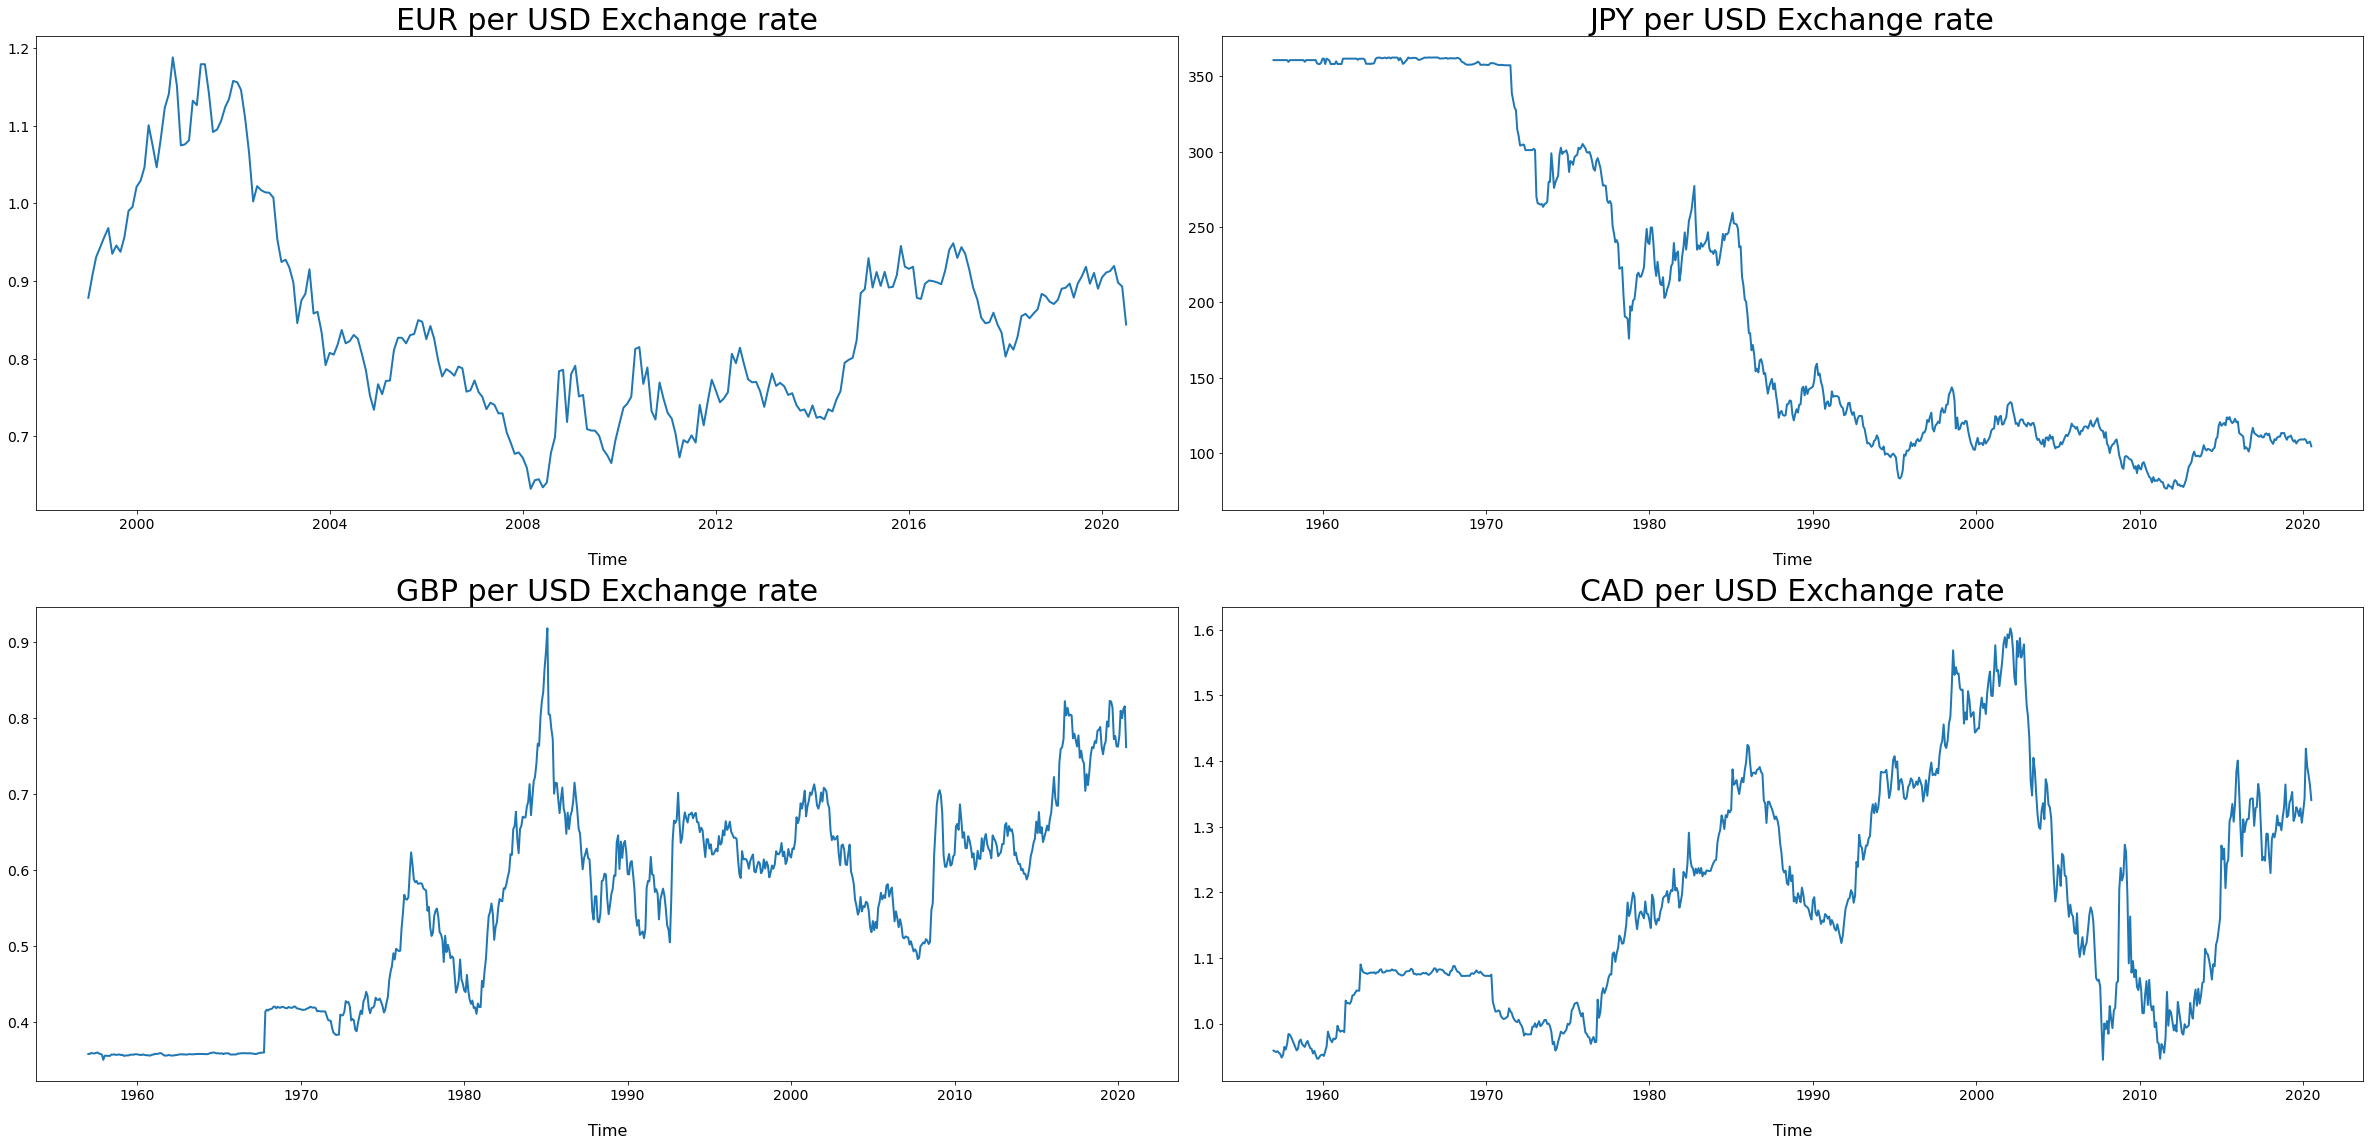

In [2]:
# Define list of country and index for data retrieve
countrylist=[['EUR', 'U2','DE'], ['JPY', 'JP','JP'], ['GBP', 'GB','GB'],['CAD','CA','CA']]
countrylist = pd.DataFrame(countrylist, columns = ['currency', 'currency_code','country_code'])
print('LIST OF CURRENCY:\n',countrylist)

# Define key input for the model
freq='M' #data frequency, can be 'M'-monthly, 'Q'-quarterly and 'A'-annually
startperiod='1950'
endperiod='2020'
fxcode= 'ENDE_XDC_USD_RATE' #data code to call data from IMF for exchange rate against USD

# Calling exchange rate data for all currencies and visualize data
df = {} # storing all FX data
plt.figure(figsize=(22*1.5,4*4)) #setting size for the charts grid

for i in range(len(countrylist)):
    currency = countrylist.loc[i,'currency']
    code = countrylist.loc[i,'currency_code']
    
    # Calling data
    df[currency]=imf_data(code,fxcode,freq,startperiod,endperiod,'@FX')
    #print(df[code].head())
    
    # Setting up visualization
    plt.subplot(len(countrylist)/2,2,i+1)
    plt.plot('@TIME_PERIOD','@FX', data=df[currency], marker='', linewidth=2)
    plt.title('{} per USD Exchange rate'.format(currency),fontsize = 30)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

plt.tight_layout(pad=1.0)
plt.show

### 2.2. Price indices for estimating PPP
Relative ppp is stated in terms of the relative inflation rates in two countries, using conventional indices: Consumer Price Indices (CPI) and Producer Price Index (PPI). In addition to these indices, we also use relative rates of inflation for US Exports and US Imports as proxy for domestic and foreign price indices. In this paper, we will exam the model using different approach in estimating PPP as follow. 

Since price indices data available for each country have different frequencies, we cannot apply monthly as the data frequency for all currencies. The only exception is Swiss France since the price indices of Swiss is only available in annual data.
As the data from IMF Database already in a structured format, ready to use in modeling, the main task before using the data for modeling is to construct the input and output variables for the training data

LIST OF DATA TYPES: 
                    desc code imf_code   color
0  Consumer Price Index  CPI  PCPI_IX     red
1  Producer Price Index  PPI  PPPI_IX   black
2    Import Price Index  PMP   PMP_IX    blue
3    Export Price Index  PXP   PXP_IX  orange

US Price Indices: 
   @TIME_PERIOD      USCPI  USPPI  USPMP  USPXP
0   1955-01-01  12.244589    NaN    NaN    NaN
1   1955-02-01  12.244589    NaN    NaN    NaN
2   1955-03-01  12.244589    NaN    NaN    NaN
3   1955-04-01  12.244589    NaN    NaN    NaN
4   1955-05-01  12.244589    NaN    NaN    NaN


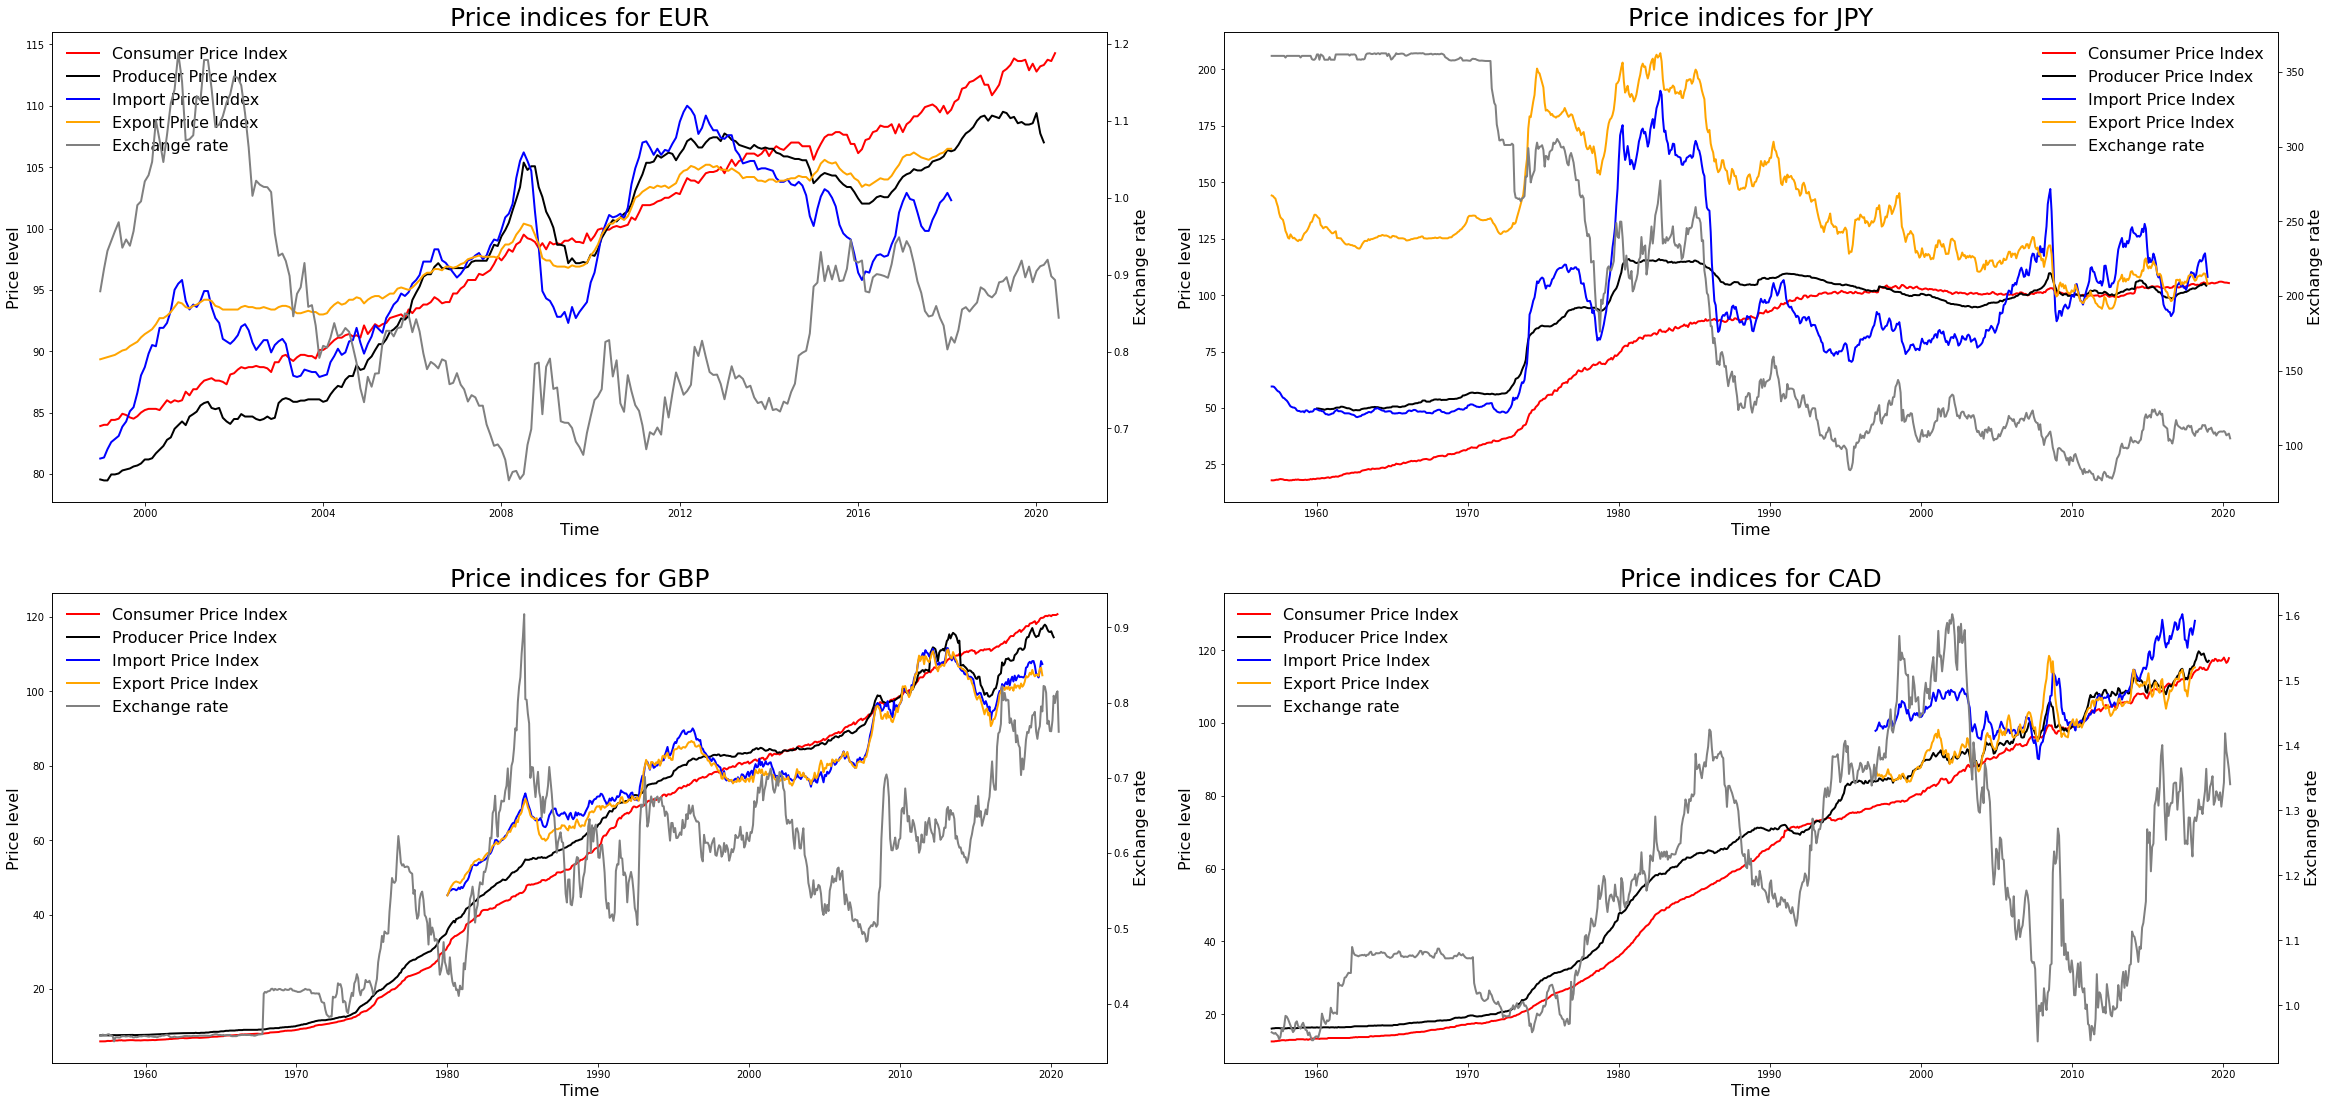

In [3]:
# Define list of data to retrived from IMF
indexlist=[['Consumer Price Index','CPI','PCPI_IX','red'],
           ['Producer Price Index','PPI','PPPI_IX','black'],
           ['Import Price Index','PMP','PMP_IX','blue'],
           ['Export Price Index','PXP','PXP_IX','orange']]
indexlist = pd.DataFrame(indexlist, columns = ['desc','code', 'imf_code','color'])
print('LIST OF DATA TYPES: \n',indexlist)

df1 = copy.deepcopy(df) # Make a copy to add data

# Calling US Price index data
country='US'
dfus = pd.DataFrame()
for i in range(len(indexlist)):
    index=indexlist.loc[i,'imf_code']
    name=country+indexlist.loc[i,'code']
    
    try:
        tem=imf_data(country,index,freq,startperiod,endperiod,name)
        dfus=pd.merge(left=dfus, right=tem, left_on='@TIME_PERIOD', right_on='@TIME_PERIOD',how='left')
    except:
        dfus=imf_data(country,index,freq,startperiod,endperiod,name)

print('\nUS Price Indices: \n',dfus.head())

# Adding Price indices to each currency and visualize the data
## Setting size for the charts grid
plt.figure(figsize=(22*1.5,4*4)) 

## Calling data and draw the chart
for i in range(len(countrylist)):
    country = countrylist.loc[i,'country_code']
    currency = countrylist.loc[i,'currency']
    ax1=plt.subplot(2,2,i+1) # setting position of the chart
    
    for j in range(len(indexlist)):
        # Setting up the name and code
        code = indexlist.loc[j,'imf_code']
        name = indexlist.loc[j,'code']
        color = indexlist.loc[j,'color']
        # Call all price index data for selected country:
        tem=imf_data(country,code,freq,startperiod,endperiod,name)
        df1[currency]=pd.merge(left=df1[currency], right=tem, left_on='@TIME_PERIOD', right_on='@TIME_PERIOD',how='left')
        # Adding data to the chart
        ax1.plot('@TIME_PERIOD',name, data=df1[currency], marker='', color=color, linewidth=2, label=indexlist.loc[j,'desc'])
        
    # Adding US price indices to each currency data:
    df1[currency]=pd.merge(left=df1[currency], right=dfus, left_on='@TIME_PERIOD', right_on='@TIME_PERIOD',how='left')
    
    # Adding exchange rate to the plot
    ax2=ax1.twinx()
    ax2.plot('@TIME_PERIOD','@FX', data=df1[currency], marker='', color='grey', linewidth=2, label='Exchange rate')
    ax2.set_ylabel('Exchange rate',fontsize = 16)
    
    # Format the chart
    ax1.set_title('Price indices for '+currency,fontsize = 25)
    ax1.set_xlabel('Time',fontsize = 16)
    ax1.set_ylabel('Price level',fontsize = 16)
    # Adding chart legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc=0,fontsize=16,facecolor='grey', framealpha=0)
    
    # Delay between data call
    time.sleep(2)

plt.tight_layout(pad=3.0)
plt.savefig('priceindices.png')
plt.show()

## 2.3. Different PPP approaches

Following the paper “Can A Relative Purchasing Power Parity-based Model Outperform A Random Walk In Forecasting Short-term Exchange Rates?” , the PPP models used here included absolute PPP, relative PPP, and the Hakkio-relative PPP equilibrium rate - an alternative representation of the concept of relative PPP. In this section, we will focus on the relative PPP and the Hakkio-relative PPP equilibrium rate approach for modelling and model configuration.

PPP is normally estimated using conventional indices: Consumer Price Indices (CPI) and Producer Price Index (PPI). In addition to these indices, we also use relative rates of inflation for US Exports and US Imports as proxy for domestic and foreign price indices. In this paper, we will exam the model using different approach in estimating PPP as follow.


In [4]:
# Define different ppp terms aproaches
ppp=pd.DataFrame()
ppp={'ppptype':['PPP1','PPP2','PPP3','PPP4'],
       'desc':['Each country CPI','Each country PXP','Each country PPI','US PMP vs. US PXP'],
       'foreign':['CPI','PXP','PPI','USPMP'],
       'us':['USCPI','USPXP','USPPI','USPXP'],
       'color':['blue','green','purple','orange']}
ppp=pd.DataFrame(ppp,columns=['ppptype','desc','foreign','us','color'])
print('LIST OF PPP APPROACHES: \n', ppp)

LIST OF PPP APPROACHES: 
   ppptype               desc foreign     us   color
0    PPP1   Each country CPI     CPI  USCPI    blue
1    PPP2   Each country PXP     PXP  USPXP   green
2    PPP3   Each country PPI     PPI  USPPI  purple
3    PPP4  US PMP vs. US PXP   USPMP  USPXP  orange


### 2.3.1. Absolute PPP
Absolute PPP is the application of the law of one price to national price levels. It postulates that the exchange rate between two countries’ currencies is equal to the ratio of the price level in one country to the price level in the other country:

![Absolute PPP formular](https://a.c-dn.net/c/content/dam/publicsites/igcom/uk/images/ContentImage/ppp_formula@2x.png)

Given that a price level represents the average price of goods in an economy, absolute PPP would hold so long as the law of one price holds on average.


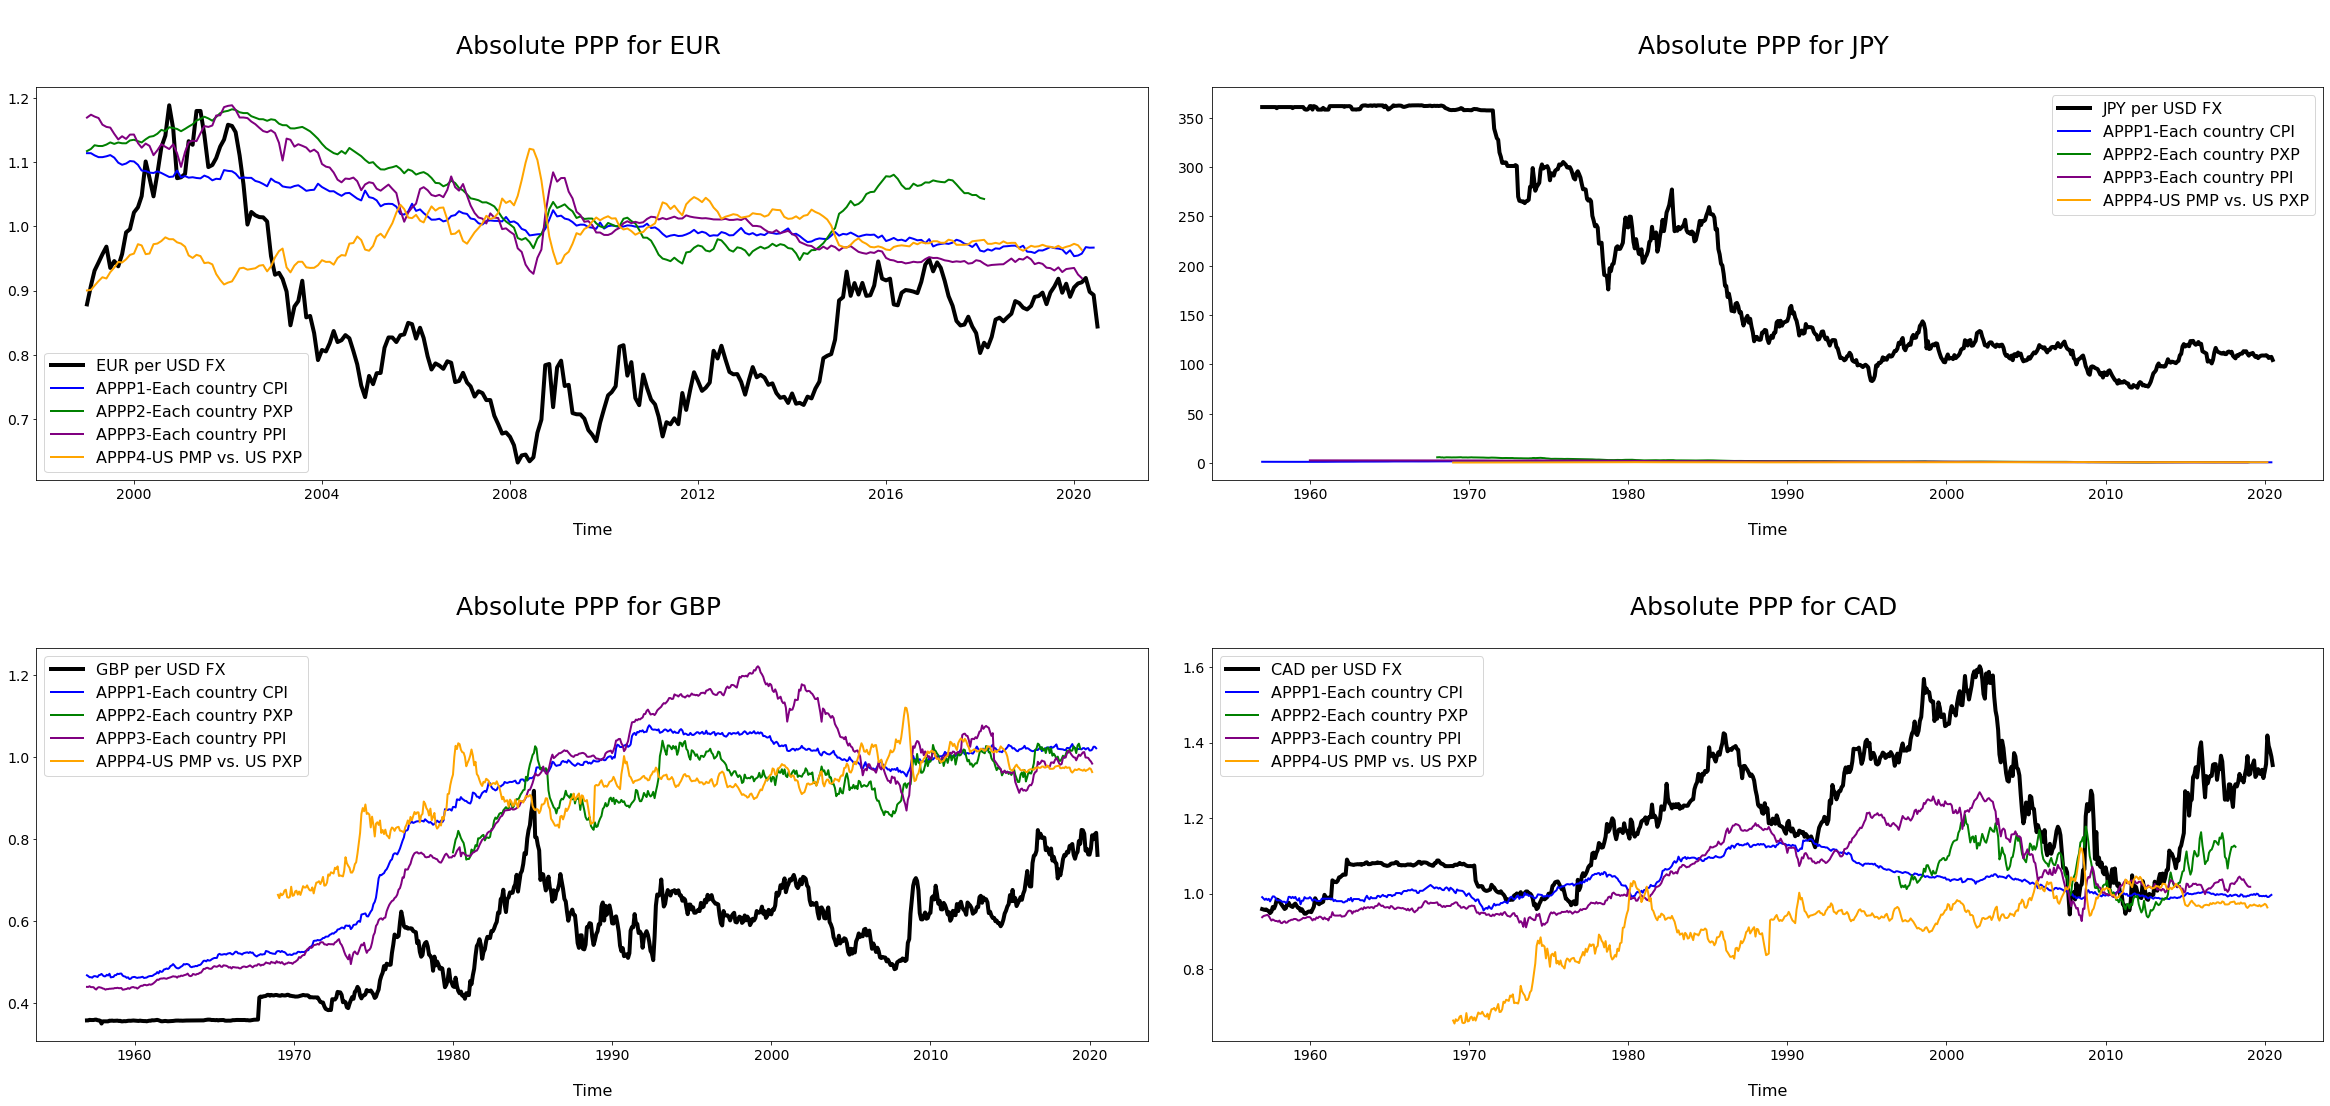

In [5]:
df2 = copy.deepcopy(df1) # Copy data to calculate PPP
plt.figure(figsize=(22*1.5,4*4)) # Set up the chart

for i in range(len(countrylist)):
    currency = countrylist.loc[i,'currency']    
    plt.subplot(2,2,i+1) # Setting position of the chart
    plt.plot('@TIME_PERIOD','@FX', data=df2[currency], marker='', color='black', linewidth=4, label='{} per USD FX'.format(currency))
    
    # Calculate absolute PPP:
    for j in range(len(ppp)):
        name='A'+ ppp.loc[j,'ppptype']
        us = ppp.loc[j,'us']
        forn = ppp.loc[j,'foreign']
        df2[currency][name]=df2[currency][forn]/df2[currency][us]
        
        # Plot the term
        label = name+'-'+ppp.loc[j,'desc']
        color = ppp.loc[j,'color']
        plt.plot('@TIME_PERIOD',name, data=df2[currency], marker='', color=color, linewidth=2, label=label)
        
    
    plt.legend(fontsize=16)
    plt.title('\nAbsolute PPP for {} \n'.format(currency),fontsize = 25)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    #print(df2[currency].head())

plt.tight_layout(pad=3.0)
plt.show()

### 2.3.2. Relative PPP
Relative PPP focuses on the primary implication of absolute PPP—that the percent change in an exchange rate should be equal to the difference in inflation rates in the two countries.

![relative PPP](https://a.c-dn.net/c/content/dam/publicsites/igcom/uk/images/ContentImage/rppp_formula@2x.png)

The charts below illustrate the change in log of exchange rate between one month apart, and the change in log of price level (using different price estimator) for the currencies of G7 countries. Depend on currencies and the nature of their economies to US economy, different proxy for price level (type of PPP)

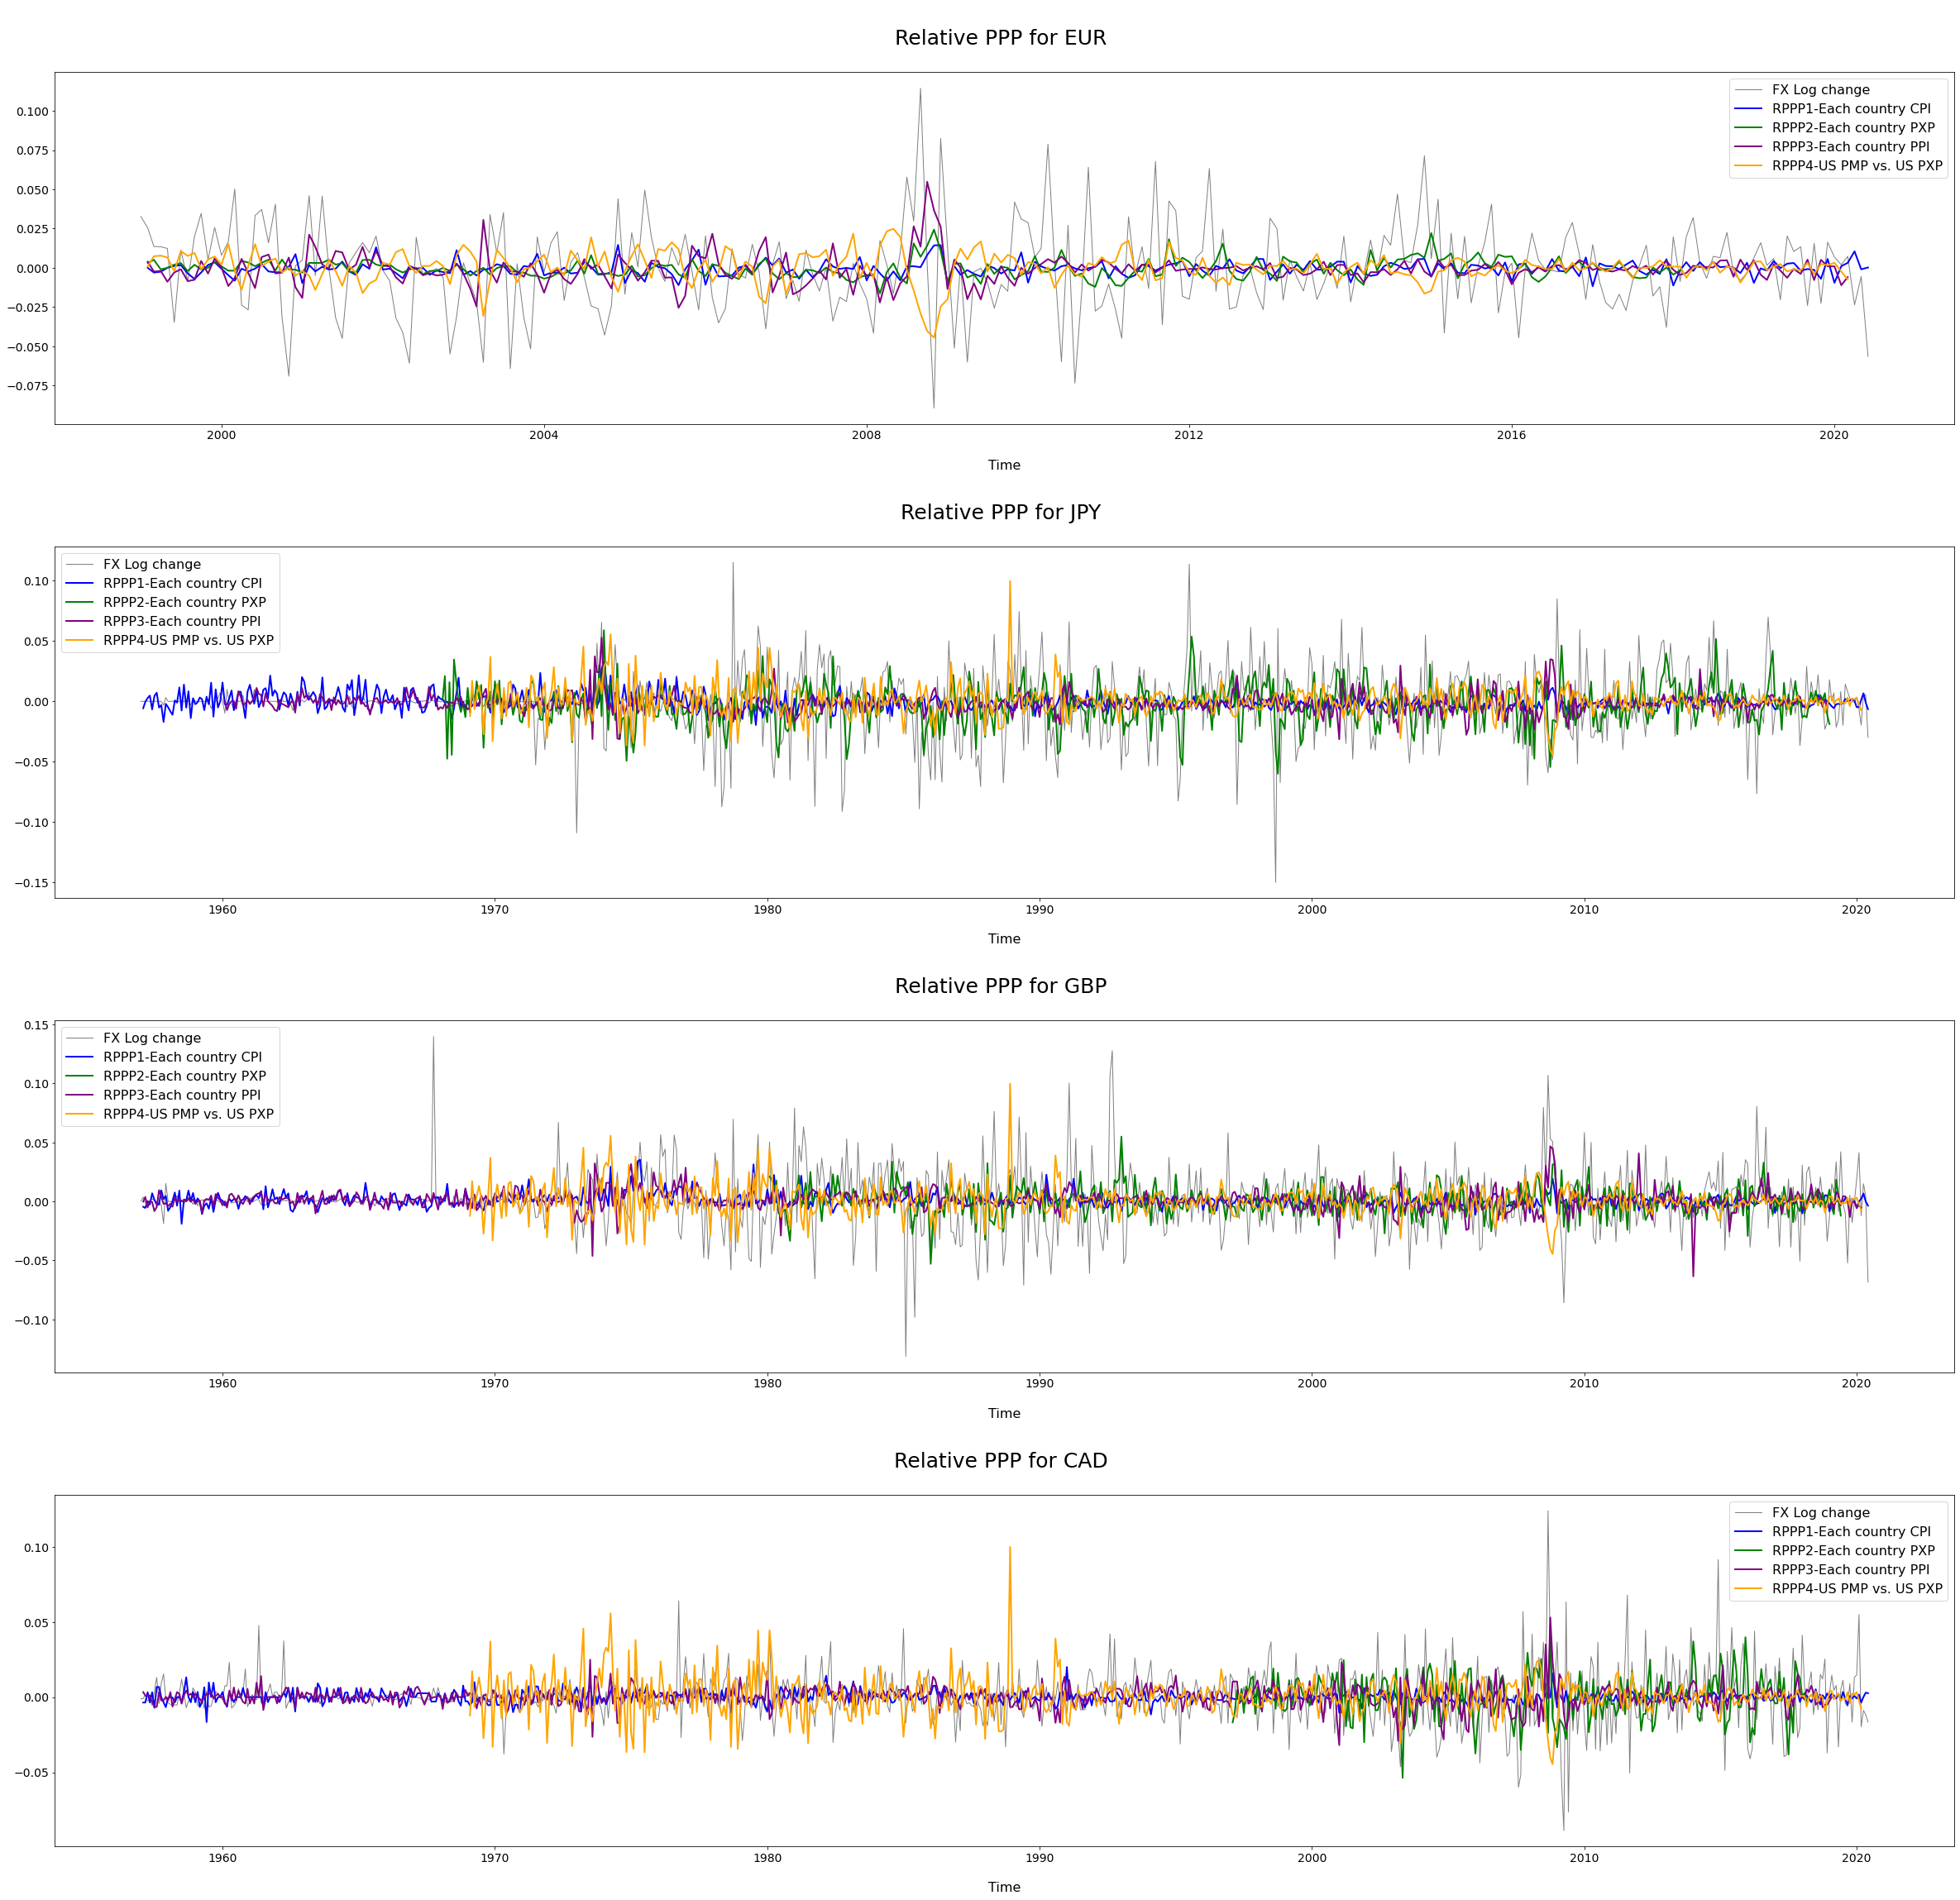

In [6]:
df3=copy.deepcopy(df1)
plt.figure(figsize=(22*1.5,4*8)) # Set up the chart

for i in range(len(countrylist)):
    currency = countrylist.loc[i,'currency']    
    plt.subplot(len(countrylist),1,i+1) # Setting position of the chart
    df3[currency]['rFX']=np.log(df3[currency]['@FX'].shift(-1))-np.log(df3[currency]['@FX'])
    plt.plot('@TIME_PERIOD','rFX', data=df3[currency], marker='', color='grey', linewidth=1, label='FX Log change')
    
    # Calculate relative PPP:
    for j in range(len(ppp)):
        ## Define name and variable
        name='R'+ ppp.loc[j,'ppptype']
        us = ppp.loc[j,'us']
        forn = ppp.loc[j,'foreign']
        
        ## Calculate change in price level
        us_ch = np.log(df3[currency][us].shift(1))-np.log(df3[currency][us])
        for_ch = np.log(df3[currency][forn].shift(1))-np.log(df3[currency][forn])
        df3[currency][name]=us_ch-for_ch
        
        # Plot the term
        label = name+'-'+ppp.loc[j,'desc']
        color = ppp.loc[j,'color']
        plt.plot('@TIME_PERIOD',name, data=df3[currency], marker='', color=color, linewidth=2, label=label)
        
    
    plt.legend(fontsize=16)
    plt.title('\nRelative PPP for {} \n'.format(currency),fontsize = 25)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    
    #print(df2[currency].head())

plt.tight_layout(pad=1.0)
plt.show()


### 2.3.3. Hakkio-relative PPP equilibrium rate
The Hakkio-relative PPP equilibrium rate is the concept of relative PPP to establish a time-varying equilibrium exchange rate. Hakkio suggests assuming that PPP holds for a specific period. One could then use that period’s observed exchange rate as a base to map the equilibrium exchange rate forward and backward from that observation using the difference in inflation in the two countries. The level of these equilibrium exchange rates, of course, is biased by the choice of the base period. To mitigate this bias one could investigate several base periods. For the scope of this project, we decided to test the model with one base period - the first period where price indices data are available. Due to data availability differences between the countries, the base period is different between currencies. In the section of data processing, we will indicate in detail the base year used for each currency.

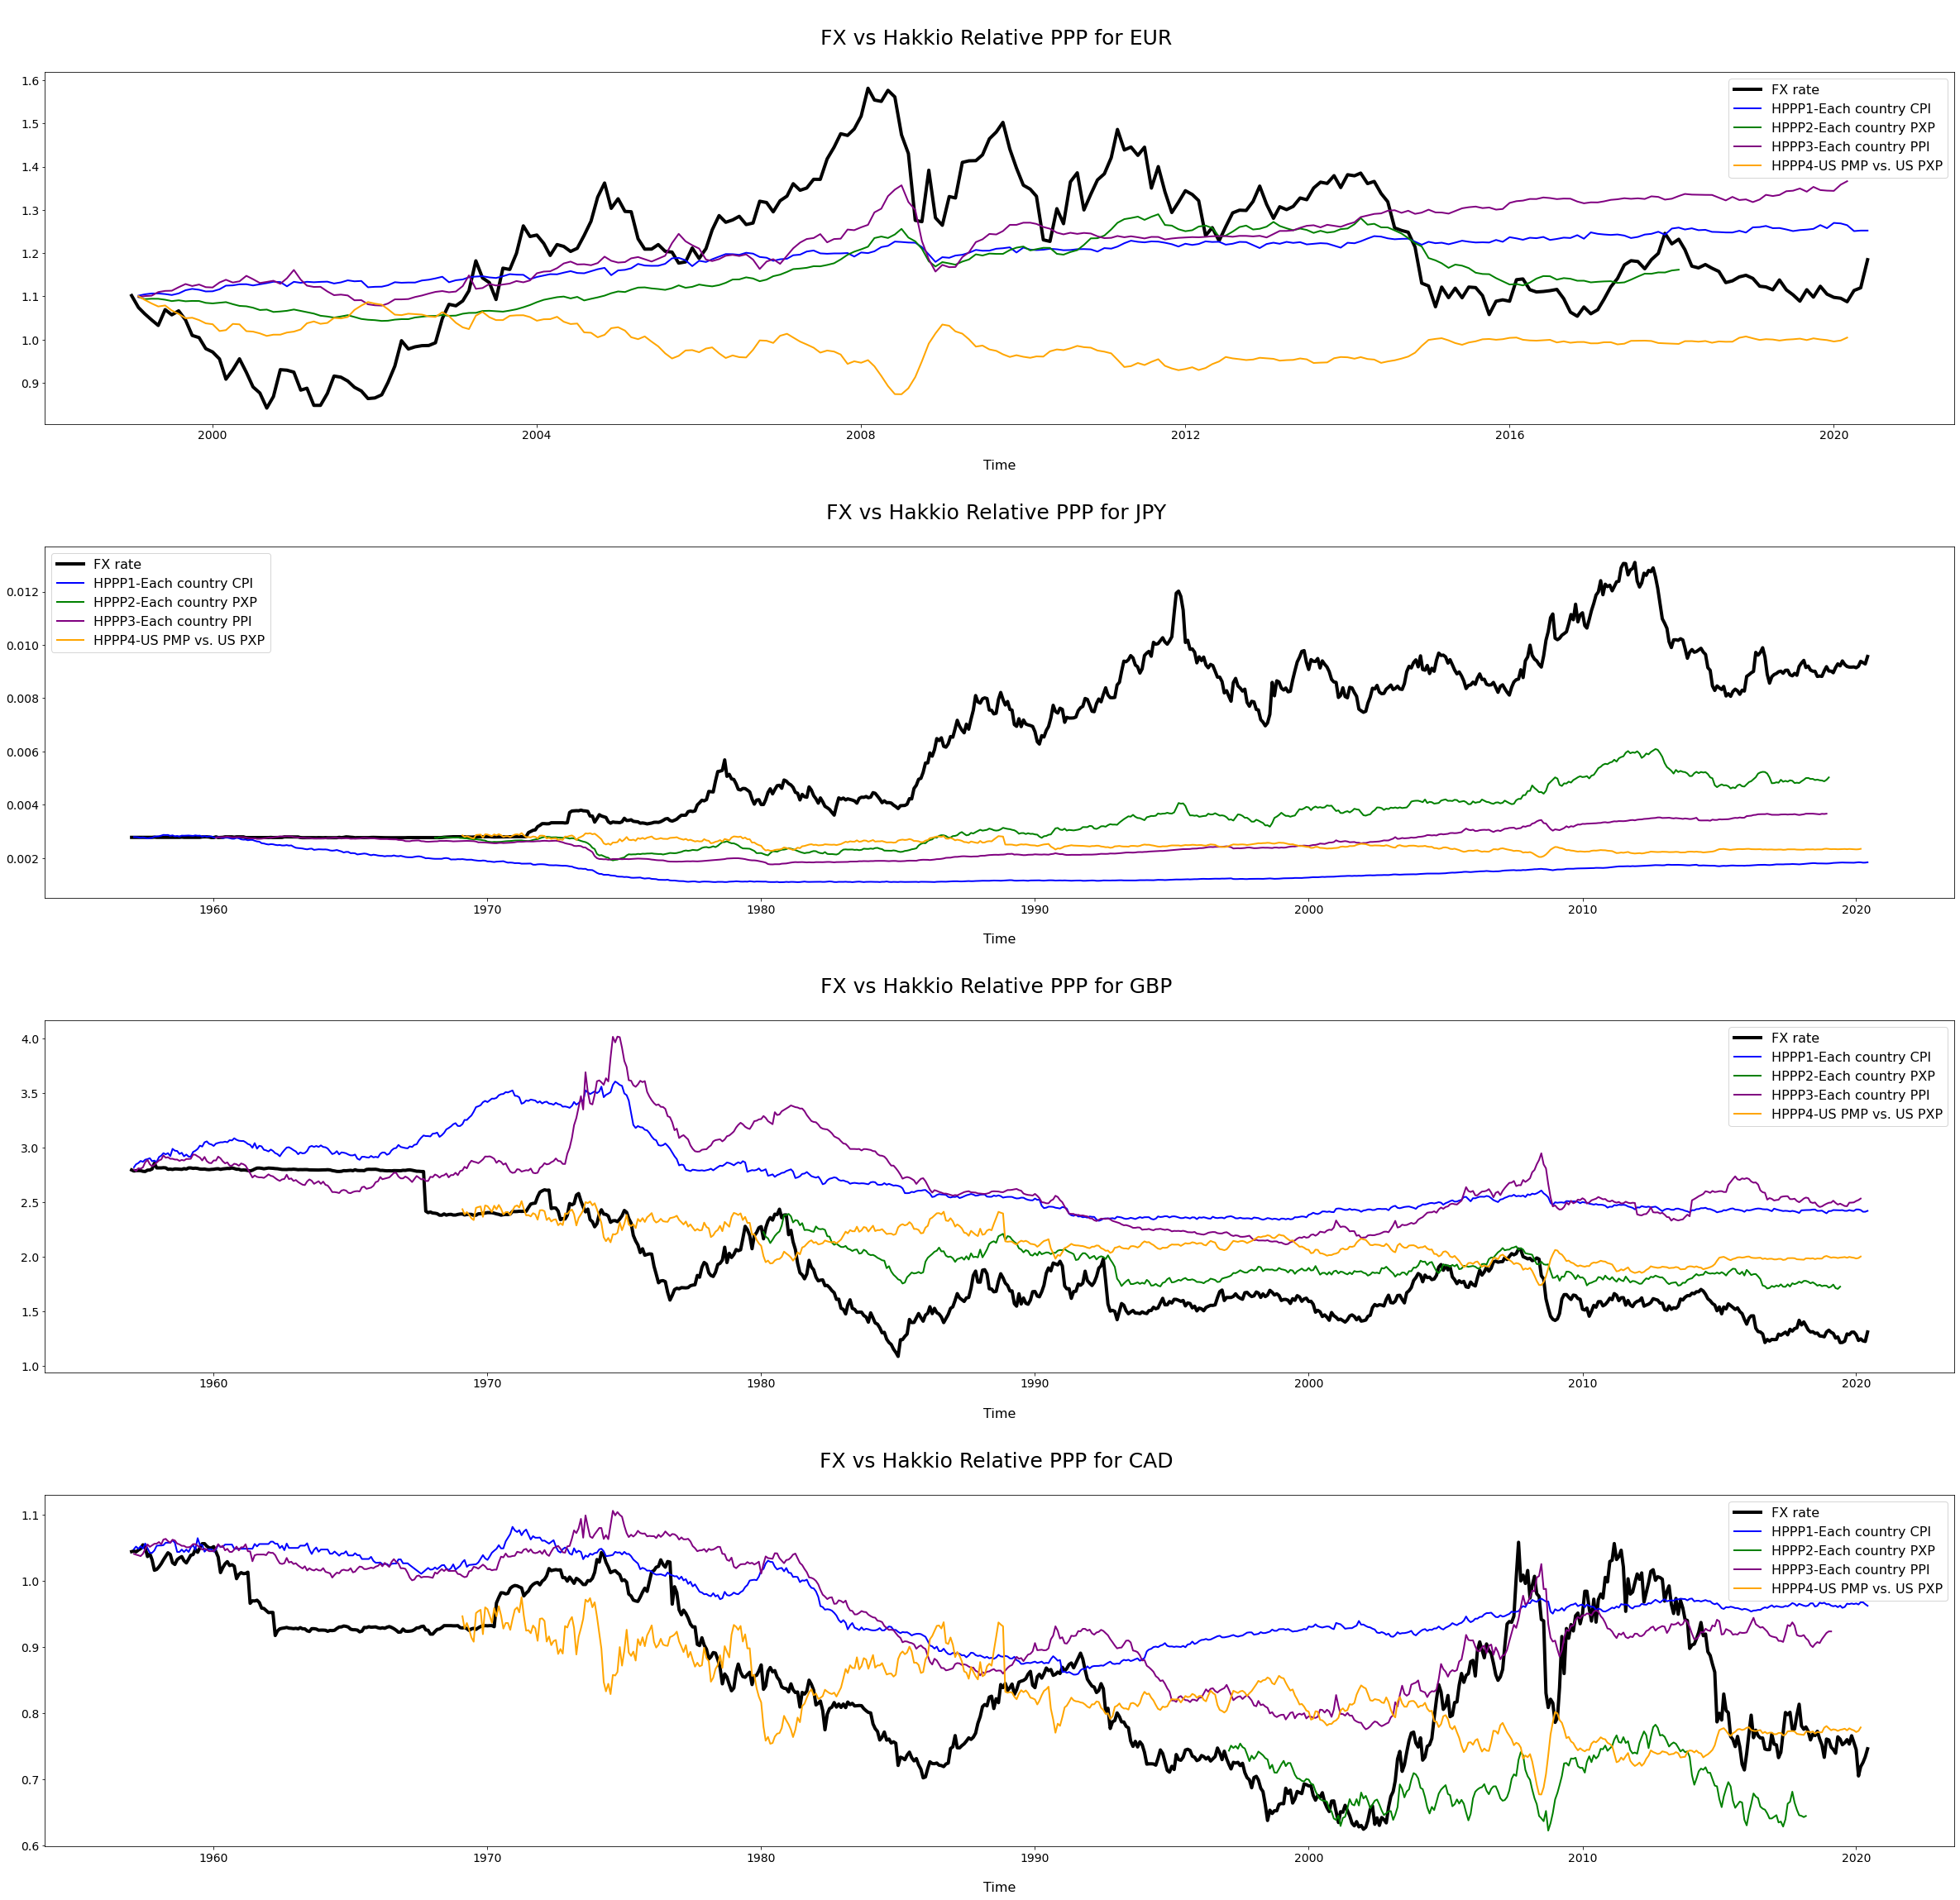

In [7]:
# Function to add relative ppp equilibrium exchange rate
def pppfx(df,time,fx,us,foreign,ppp):
    tem=df[[time,fx,us,foreign]].copy(deep=True)
    # Calculate % change in price level
    tem['us_in']=(tem[us]-tem[us].shift(1))/tem[foreign].shift(1)
    tem['eu_in']=(tem[foreign]-tem[foreign].shift(1))/tem[foreign].shift(1)
    tem=tem.dropna().reset_index(drop = True) 
    # Calculate Hakkio relative PPP term
    for i in range(len(tem)):
        if i==0: # Select base year
            tem.loc[i,ppp]=tem.loc[i,fx]*(1+tem.loc[i,'us_in']-tem.loc[i,'eu_in'])
        else: # Calculate on the base year
            tem.loc[i,ppp]=tem.loc[i-1,ppp]*(1+tem.loc[i,'us_in']-tem.loc[i,'eu_in'])
    # Format the data
    tem[ppp]=tem[ppp].astype(float)
    return tem[[time,ppp]]

## Calculate and visualize Hakkio relative PPP
df4=copy.deepcopy(df1)
plt.figure(figsize=(22*1.5,4*8)) # Set up the chart

for i in range(len(countrylist)):
    currency = countrylist.loc[i,'currency']    
    plt.subplot(len(countrylist),1,i+1) # Setting position of the chart
    
    # Transform FX to calculate
    df4[currency]['@FX']=1/df4[currency]['@FX']
    df4[currency]['fFX']=df4[currency]['@FX'].shift(-1)
    
    # Plot the exchange rate
    plt.plot('@TIME_PERIOD','fFX', data=df4[currency], marker='', color='black', linewidth=4, label='FX rate')
    
    # Calculate Hakkio-relative PPP:
    for j in range(len(ppp)):
        ## Define name and variable
        name='H'+ ppp.loc[j,'ppptype']
        us = ppp.loc[j,'us']
        forn = ppp.loc[j,'foreign']
        
        ## Calculate change in price level
        tem = pppfx(df4[currency],'@TIME_PERIOD','@FX',us,forn,name)
        df4[currency]=pd.merge(left=df4[currency], right=tem, left_on='@TIME_PERIOD', right_on='@TIME_PERIOD',how='left')
        
        # Plot the term
        label = name+'-'+ppp.loc[j,'desc']
        color = ppp.loc[j,'color']
        plt.plot('@TIME_PERIOD',name, data=df4[currency], marker='', color=color, linewidth=2, label=label)
        
    
    # Format the chart
    plt.legend(fontsize=16)
    plt.title('\nFX vs Hakkio Relative PPP for {} \n'.format(currency),fontsize = 25)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

plt.tight_layout(pad=1.0)
plt.show()

## 3. Model
In the section, we will review the model to predict the FX rate of month t+k (k=1, 3, 6 and 12 months) with the data available at month t following previous research on PPP, relative PPP and Hakkio relative PPP

To compare the forecast performance, two key criteria will be employed: (1) the ratio between the mean squared error (MSE) of the structural models and a driftless random walk; and (2) an alternative evaluation metric - the proportion of forecasts that correctly predict the direction of the dollar exchange rate movement. Overall, the MSE results are not particularly favorable to the structural models but the direction change prediction showed mixed evidence on the ability of the structural models to correctly predict the direction of change. Therefore, the 2nd criteria will be the main performance criteria for selecting the best model to predict FX.

We will follow two different approaches:

3.1. Original models
* The random walk model
* Original relative PPP model - Regression OLS
* Original Hakkio-relative PPP - Regression OLS

3.2. Configured models
* Hakkio-relative PPP - Regression OLS with moving average of FX
* Hakkio-relative PPP - Regression OLS with lagging effects

Key inputs for model training across different approach are:


In [8]:
listk = [1,3,6,12]
cutoff = '2009-12-31'
result={}
print('Cut off time to train model:', cutoff)
print('Model is trained in predicting exchange rate of {} months from now'.format(listk))
print('Models are evaluated again each others based on: MSE and accuracy of direction predicted correctly')

Cut off time to train model: 2009-12-31
Model is trained in predicting exchange rate of [1, 3, 6, 12] months from now
Models are evaluated again each others based on: MSE and accuracy of direction predicted correctly



## 3.1. Original models

### 3.1.1. Random walk

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period. Instead, it may be better to try to predict the change that occurs from one period to the next

![relative PPP](https://slideplayer.com/slide/4283195/14/images/46/Random+Walk+The+equation+in+the+previous+slide+can+be+rewritten+as.jpg)

Mean square error (mse) and %change in direction predicted correctly (accuracy) by the random walk model for each currency


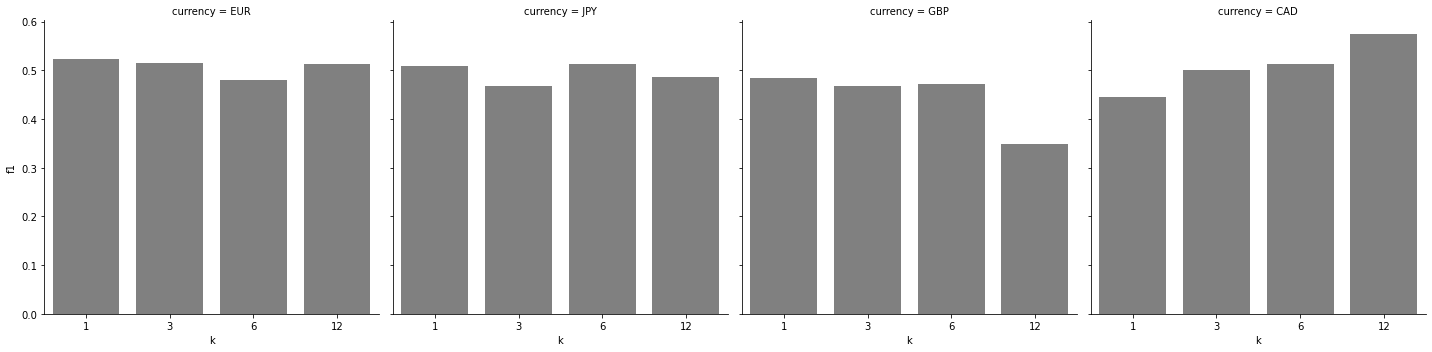

In [104]:
def randomwalk(df1,k,cutoff):
    
    '''This function take in the data of FX and date, train a simple regression mode with cutoff date
    return the two key model performance: Mean square error and F1 - %change in direction correctly predicted'''
    
    # Copy the data to work on
    df=df1.copy(deep=True)
    
    # Adding output variables
    df['y']=df['@FX'].shift(-k) # Exchange rate of k month from now
    df=df.dropna()
    df['cdir']=(df['y']-df['@FX']).map(lambda x: 1 if x>0 else 0) # Increase or decrease in FX in k months from now
    
    # Splitting data to train and test
    train=df[df['@TIME_PERIOD']<cutoff]
    test=df[df['@TIME_PERIOD']>cutoff]
    x=np.asanyarray(train['@FX']).reshape(-1, 1)
    y=np.asanyarray(train['y']).reshape(-1, 1)
    
    # Training the mode
    regr = linear_model.LinearRegression()
    regr.fit (x,y)
    
    # Testing on the test data set
    xtest=np.asanyarray(test['@FX']).reshape(-1, 1)
    ytest=np.asanyarray(test['y']).reshape(-1, 1)
    ypred=regr.predict(xtest)
    pcdir = (ypred - xtest)
    pcdir = (pcdir > 0).astype(int)
    
    # Writing down model performance
    mse = mean_squared_error(test.loc[:,'y'], ypred) # Mean square error
    accuracy = accuracy_score(test.loc[:,'cdir'],pcdir) # % of change in direction correctly predicted
    
    return mse, accuracy

result['randomwalk']={'currency':[],'model':[],'k':[],'mse':[],'f1':[]} # to store all model performance
metrics = list(result['randomwalk'].keys())

print('Mean square error (mse) and %change in direction predicted correctly (accuracy) by the random walk model for each currency')
for i, currency in enumerate(countrylist['currency']):
    for k in listk:
        mse,f1 = randomwalk(df[currency],k,cutoff)
        result['randomwalk']['currency'].append(currency)
        result['randomwalk']['model'].append('Random Walk')
        result['randomwalk']['k'].append(k)
        result['randomwalk']['mse'].append(mse)
        result['randomwalk']['f1'].append(f1)


sns.catplot("k", y="f1", data=pd.DataFrame(result['randomwalk'],columns=metrics),col="currency",color='grey',kind="bar")

### 3.1.2. Original relative PPP model - Regression OLS

This model approach aimt to predict the change in log of FX k month into the future from the current month t using the input variable is the change in log of price level in the US and the foreign country.

![relativeppp](https://slideplayer.com/slide/5925028/19/images/17/Relative+Purchasing+Power+Parity.jpg)

Mean square error (mse) and %change in direction predicted correctly (accuracy) by the random walk model for each currency


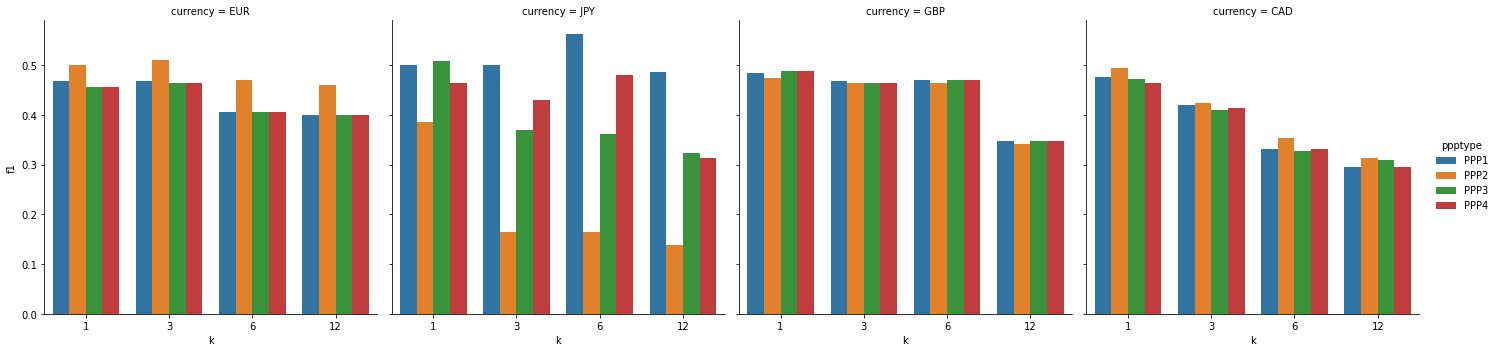

In [61]:
def pppols(df1,k,us,foreign,cutoff):
    
    # Make a copy of data to work on
    df=df1[['@TIME_PERIOD','@FX',us,foreign]].copy(deep=True)
    
    # Adding output variables
    ## Create y = Future exchange rate k month from now
    df['y']=df['@FX'].shift(-k)
    
    ## Create x = %Change in price level in US and foreign country
    df['us_ch'] = (df[us]-df[us].shift(k))/(df[us].shift(k))
    df['for_ch'] = (df[foreign]-df[foreign].shift(k))/(df[foreign].shift(k))
    df['x']= df['@FX']*(1+df['for_ch'])/(1+df['us_ch']) # Change in log price level as input variable
    
    ## Create cdir = Increase or decrease in FX in k months from now (for model evaluation later)
    df['cdir']=(df['y']-df['@FX']).map(lambda x: 1 if x>0 else 0) 
    
    ## Drop NA data
    df=df.dropna().reset_index(drop=True) # Drop NA value
    
    # Splitting data to train and test
    train=df[df['@TIME_PERIOD']<cutoff]
    test=df[df['@TIME_PERIOD']>cutoff]
    x=np.asanyarray(train['x']).reshape(-1, 1)
    y=np.asanyarray(train['y']).reshape(-1, 1)
    
    
    # Training the mode
    regr = linear_model.LinearRegression()
    regr.fit (x,y)
    
    # Testing on the test data set
    xtest=np.asanyarray(test['x']).reshape(-1, 1)
    ytest=np.asanyarray(test['y']).reshape(-1, 1)
    ypred=regr.predict(xtest)
    
    # Transform y to change in direction
    pcdir = (ypred - np.asanyarray(test['@FX']).reshape(-1, 1)).astype(int)
    
    
    # Writing down model performance
    mse = mean_squared_error(test['y'], ypred) # Mean square error
    accuracy = accuracy_score(test['cdir'],pcdir) # % of change in direction correctly predicted

    return mse, accuracy

# Create dictionary to store all model performance
result['rppp']={'currency':[],'model':[],'k':[],'ppptype':[],'mse':[],'f1':[]} 
metrics = list(result['rppp'].keys())
print('Mean square error (mse) and %change in direction predicted correctly (accuracy) by the random walk model for each currency')

# Running model and record data
for currency in countrylist['currency']:
    # Setting up data frame to record data
    for k in listk:
        # Emty dict to record performance metrics
        for i in range(len(ppp)):
            us = ppp.loc[i,'us']
            foreign = ppp.loc[i,'foreign']
            mse, f1 = pppols(df1[currency],k,us,foreign,cutoff)
            
            # Record data into the dict
            result['rppp']['currency'].append(currency)
            result['rppp']['model'].append('Relative PPP OLS')
            result['rppp']['k'].append(k)
            result['rppp']['ppptype'].append(ppp.loc[i,'ppptype'])
            result['rppp']['mse'].append(mse)
            result['rppp']['f1'].append(f1)

sns.catplot("k", y="f1", data=pd.DataFrame(result['rppp'],columns=metrics),hue="ppptype",col="currency",kind="bar")

### 3.1.3. Original Hakkio-relative PPP - Regression OLS

This model approach is to predict the change in log of exchange rate using the different between log of the current month exchange rate and log of the relative ppp equilibrium exchange rate at time

Mean square error (mse) and %change in direction predicted correctly (accuracy) by Hakkio equilibrium fx for each currency


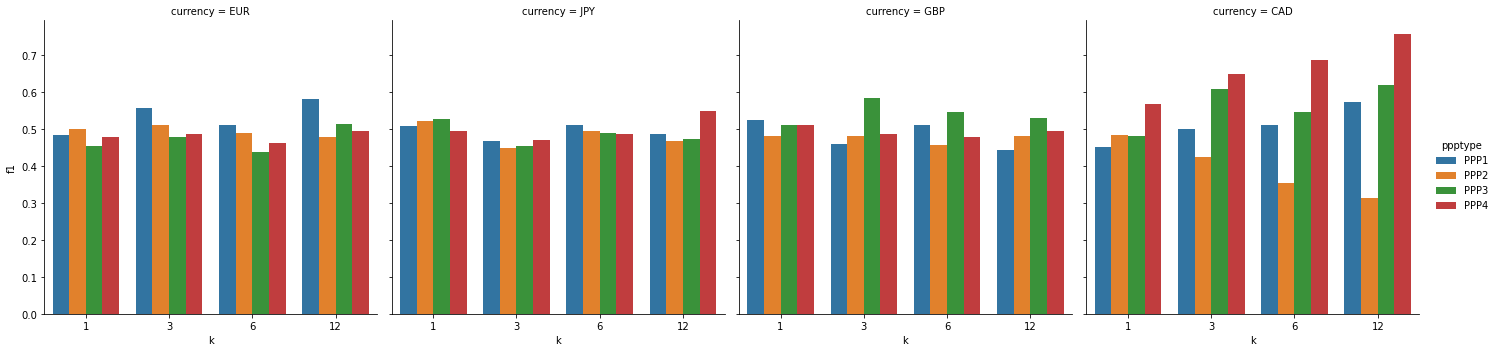

In [65]:
def hppp(df1,k,hppp,cutoff):

    # Make a copy of data to work on
    df=df1[['@TIME_PERIOD','@FX',hppp]].copy(deep=True)
    
    # Adding output variables
    ## Create y = Change in log exchange rate
    df['fFX'] = df['@FX'].shift(-k)
    df['y']= np.log(df['fFX'])-np.log(df['@FX']) 
    ## Create x = Change in log of current month fx and relative ppp equilibrium fx
    df['x']= np.log(df['@FX']) - np.log(df[hppp])
    ## Create cdir = Increase or decrease in FX in k months from now (for model evaluation later)
    df['cdir']=(df['fFX']-df['@FX']).map(lambda x: 1 if x>0 else 0) 
    ## Drop NA data
    df=df.dropna().reset_index(drop=True) # Drop NA value
    
    # Splitting data to train and test
    train=df[df['@TIME_PERIOD']<cutoff]
    test=df[df['@TIME_PERIOD']>cutoff]
    x=np.asanyarray(train['x']).reshape(-1, 1)
    y=np.asanyarray(train['y']).reshape(-1, 1)
    
    # Training the mode
    regr = linear_model.LinearRegression()
    regr.fit (x,y)
    
    # Testing on the test data set
    xtest=np.asanyarray(test['x']).reshape(-1, 1)
    ytest=np.asanyarray(test['y']).reshape(-1, 1)
    ypred=regr.predict(xtest)
    fxpred=np.exp(ypred + np.asanyarray(np.log(test['@FX'])).reshape(-1, 1))
    pcdir = (fxpred - np.asanyarray(test['@FX']).reshape(-1, 1) > 0).astype(int)
    
    # Writing down model performance
    mse = mean_squared_error(test['fFX'], fxpred) # Mean square error
    accuracy = accuracy_score(test['cdir'],pcdir) # % of change in direction correctly predicted
    
    return mse, accuracy

# Create dictionary to store all model performance
result['hppp']={'currency':[],'model':[],'k':[],'ppptype':[],'mse':[],'f1':[]} 
metrics = list(result['hppp'].keys())
print('%Change in direction predicted correctly (accuracy) by Hakkio equilibrium fx for each currency')

# Running model and record data
for currency in countrylist['currency']:
    # Setting up data frame to record data
    for k in listk:
        # Emty dict to record performance metrics
        for i in range(len(ppp)):
            ppptype = 'H'+ppp.loc[i,'ppptype']
            mse, f1 = hppp(df4[currency][['@TIME_PERIOD','@FX',ppptype]],k,ppptype,cutoff)
            
            # Record data into the dict
            result['hppp']['currency'].append(currency)
            result['hppp']['model'].append('Hakkio relative PPP OLS')
            result['hppp']['k'].append(k)
            result['hppp']['ppptype'].append(ppp.loc[i,'ppptype'])
            result['hppp']['mse'].append(mse)
            result['hppp']['f1'].append(f1)
            
sns.catplot("k", y="f1", data=pd.DataFrame(result['hppp'],columns=metrics),hue="ppptype",col="currency",kind="bar")

## 3.2. Configured models

### 3.2.1. Hakkio-relative PPP - Regression OLS with moving average of FX

If we looking back to the relative PPP and changes in FX (section 2.3.2), noise in the FX is very difficult for the captured by the change in price indices from both domestic and foreign country. On the other hands, if we are looking at the purpose of the FX risk management, the information of how the exchange rate in k month from now is higher or lower than the average exchange rate of the last 3, 6 or 12 months can still be helpful for the user. Therefore, a moving average exchange rate can be use in this case in place of the current month exchange rate to help predict the future exchange rate.


<function matplotlib.pyplot.show(*args, **kw)>

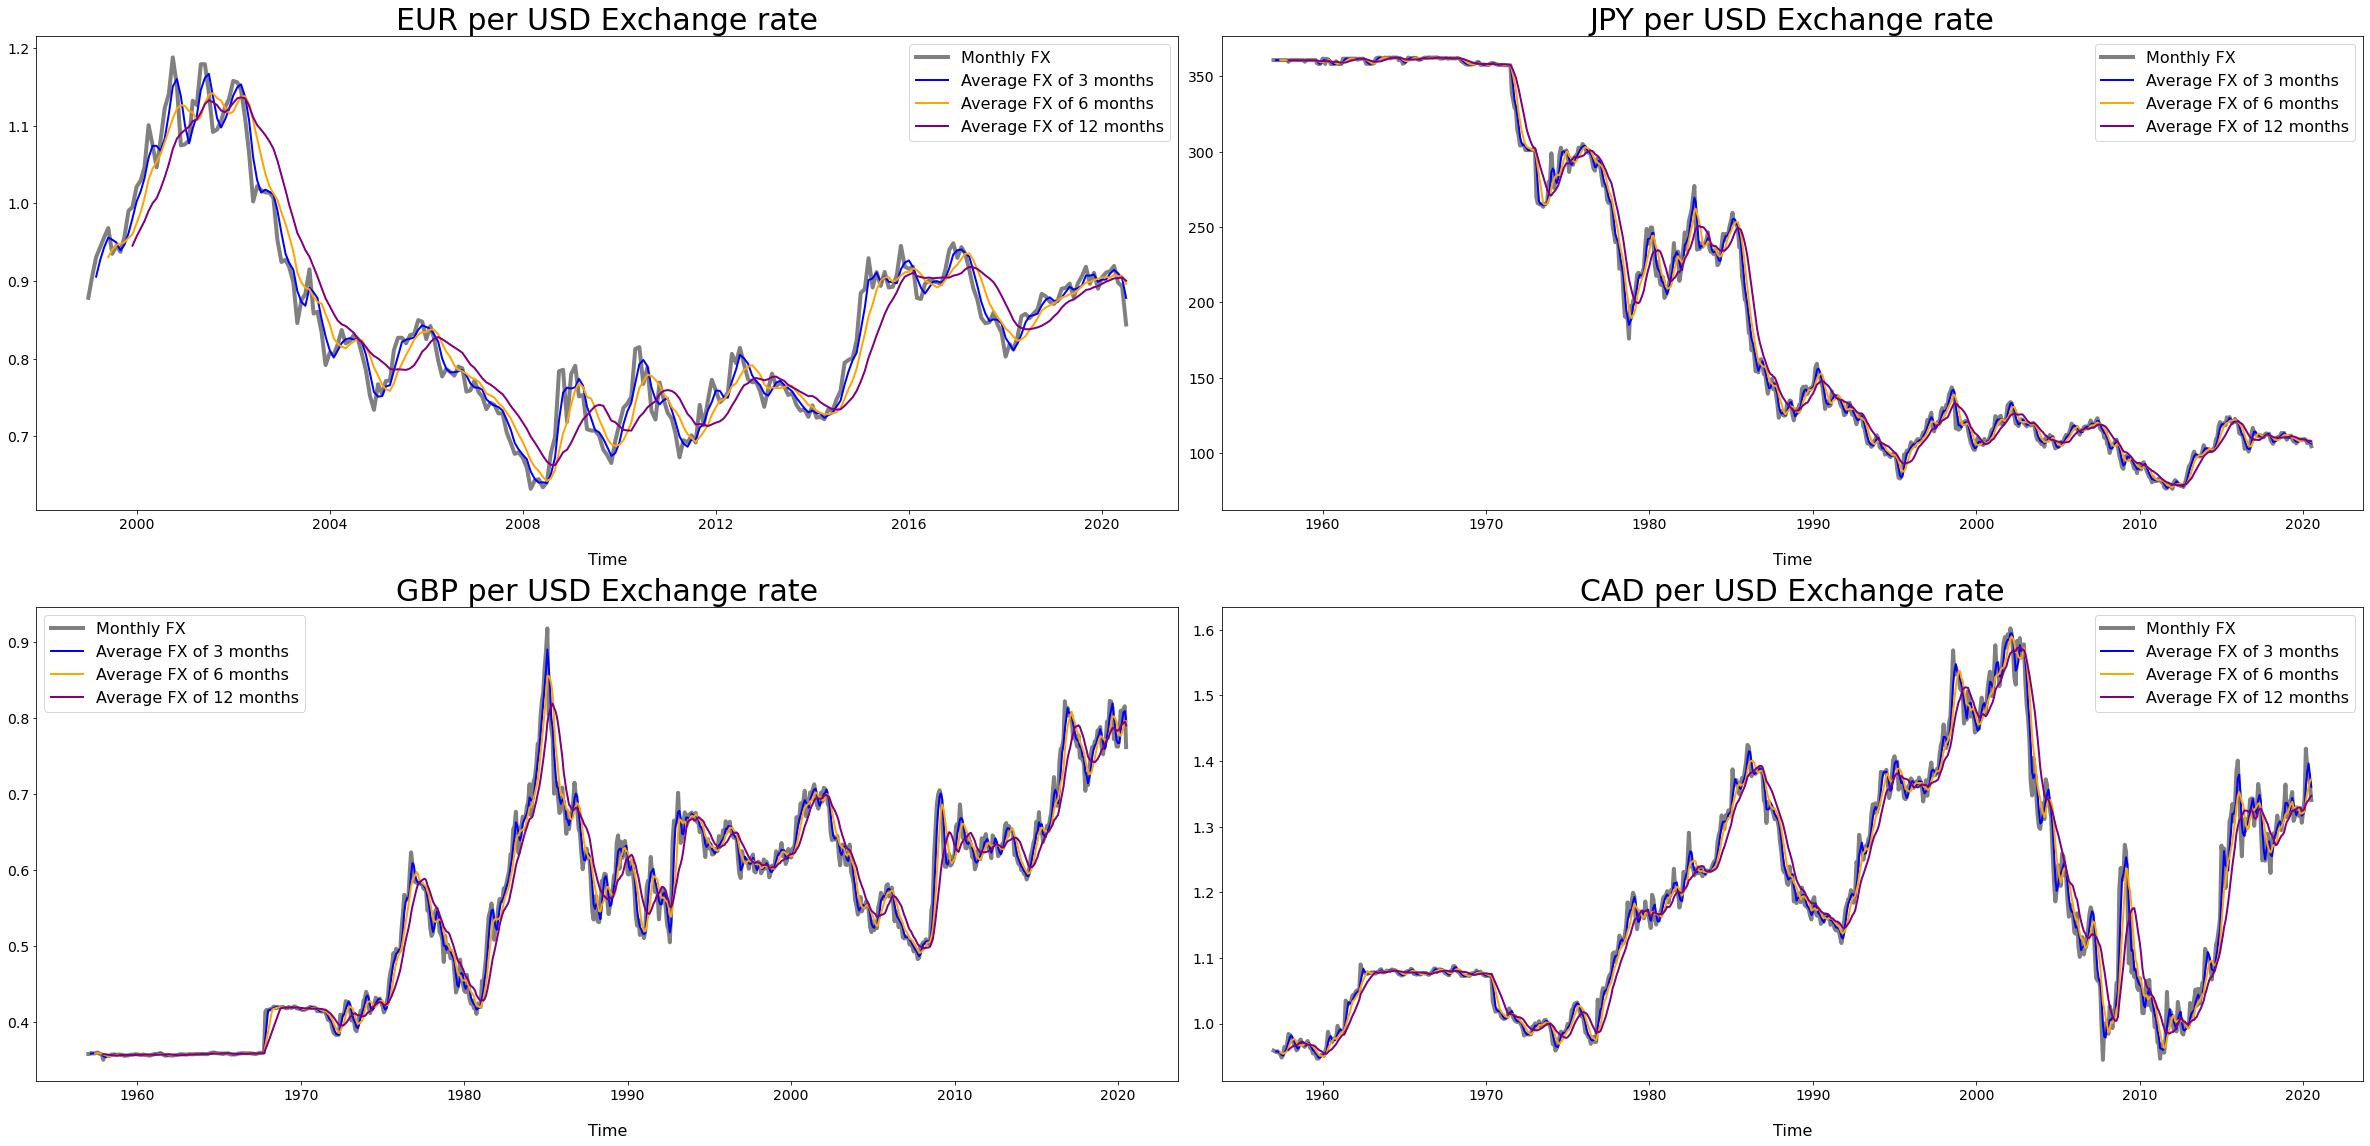

In [73]:
mav = {3:'blue',6:'orange',12:'purple'}
plt.figure(figsize=(22*1.5,4*4)) #setting size for the charts grid
for i,currency in enumerate(countrylist['currency']):
    currency=countrylist.loc[i,'currency']
    
    # Setting up visualization
    plt.subplot(len(countrylist)/2,2,i+1)
    plt.plot('@TIME_PERIOD','@FX', data=df[currency], color='grey', label = 'Monthly FX' ,linewidth=4)
    
    for av in mav.keys():
        plt.plot(df[currency]['@TIME_PERIOD'], df[currency]['@FX'].rolling(window=av).mean() , color=mav[av], label = 'Average FX of {} months'.format(av) ,linewidth=2)
    
    plt.title('{} per USD Exchange rate'.format(currency),fontsize = 30)
    plt.xlabel('\nTime',fontsize = 16)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize=16)

plt.tight_layout(pad=1.0)
plt.show

%Change in direction predicted correctly (accuracy) by Hakkio equilibrium fx using moving average for each currency


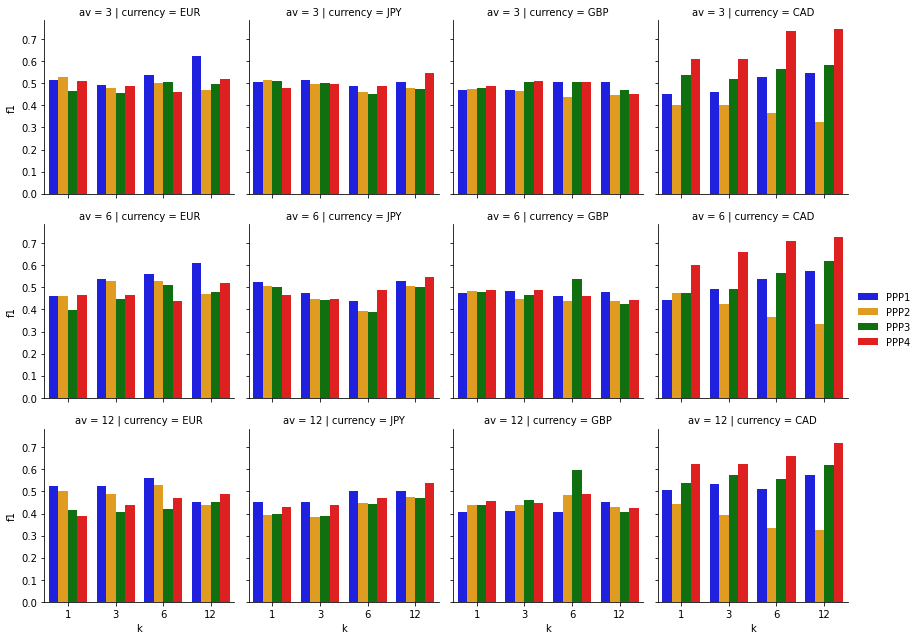

In [100]:
def maver(df1,k,av,hppp,cutoff):

    # Make a copy of data to work on
    df=df1[['@TIME_PERIOD','@FX',hppp]].copy(deep=True)
    
    # Adding output variables
    ## Create y = Change in log exchange rate
    df['fFX'] = df['@FX'].shift(-k)
    df['y']= np.log(df['fFX'])-np.log(df['@FX']) 
    ## Create x = Change in log of average fx last k month and relative ppp equilibrium fx
    df['aFX'] = df['@FX'].rolling(window=av).mean()
    df['x']= np.log(df['aFX']) - np.log(df[hppp])
    ## Create cdir = Increase or decrease in FX in k months from now (for model evaluation later)
    df['cdir']=(df['fFX']-df['aFX']).map(lambda x: 1 if x>0 else 0) 
    ## Drop NA data
    df=df.dropna().reset_index(drop=True) # Drop NA value
    
    # Splitting data to train and test
    train=df[df['@TIME_PERIOD']<cutoff]
    test=df[df['@TIME_PERIOD']>cutoff]
    x=np.asanyarray(train['x']).reshape(-1, 1)
    y=np.asanyarray(train['y']).reshape(-1, 1)
    
    # Training the mode
    regr = linear_model.LinearRegression()
    regr.fit (x,y)
    
    # Testing on the test data set
    xtest=np.asanyarray(test['x']).reshape(-1, 1)
    ytest=np.asanyarray(test['y']).reshape(-1, 1)
    ypred=regr.predict(xtest)
    fxpred=np.exp(ypred + np.asanyarray(np.log(test['aFX'])).reshape(-1, 1))
    pcdir = (fxpred - np.asanyarray(test['aFX']).reshape(-1, 1) > 0).astype(int)
    
    # Writing down model performance
    mse = mean_squared_error(test['fFX'], fxpred) # Mean square error
    accuracy = accuracy_score(test['cdir'],pcdir) # % of change in direction correctly predicted
    
    return mse, accuracy

# Create dictionary to store all model performance
result['mav']={'currency':[],'model':[],'k':[],'av':[],'ppptype':[],'mse':[],'f1':[]} 
metrics = list(result['mav'].keys())
print('%Change in direction predicted correctly (accuracy) by Hakkio equilibrium fx using moving average for each currency')

# Running model and record data
for currency in countrylist['currency']:
    # Setting up data frame to record data
    for k in listk:
        for i in range(len(ppp)):
            ppptype = 'H'+ppp.loc[i,'ppptype']
            for av in mav.keys():
                mse, f1 = maver(df4[currency][['@TIME_PERIOD','@FX',ppptype]],k,av,ppptype,cutoff)

                # Record data into the dict
                result['mav']['currency'].append(currency)
                result['mav']['model'].append('Hakkio relative PPP OLS')
                result['mav']['k'].append(k)
                result['mav']['av'].append(av)
                result['mav']['ppptype'].append(ppp.loc[i,'ppptype'])
                result['mav']['mse'].append(mse)
                result['mav']['f1'].append(f1)

g = sns.FacetGrid(pd.DataFrame(result['mav'],columns=metrics), col="currency", row="av")
g.map(sns.barplot, "k", "f1","ppptype",
      hue_order=ppp["ppptype"],
      order=listk,
      palette=sns.color_palette(['blue','orange','green','red'])).add_legend()

### 3.2.2. Hakkio-relative PPP - Regression OLS with lagging effects

Since there is always a lag in FX response to changes in macroeconomics factor such as price level, this model approach aim at adding the changes of previous months to the function with hope of improving the modelling prediction performance.
In this case, we will model with adding the lagging effect from 3, 6 and 12 months before the current month to predict the next month exchange rate

%Change in direction predicted correctly (accuracy) by Hakkio equilibrium fx using lagging effect for each currency


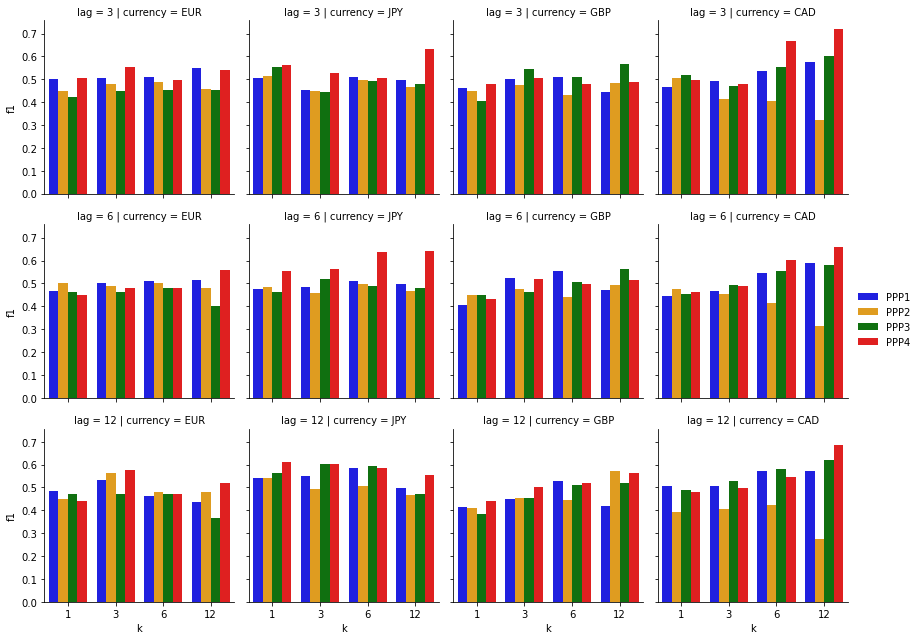

In [151]:
def lagppp(df1,k,lag,hppp,cutoff):

    # Make a copy of data to work on
    df=df1[['@TIME_PERIOD','@FX',hppp]].copy(deep=True)
    
    # Adding output variables
    ## Create y = Change in log exchange rate
    df['fFX'] = df['@FX'].shift(-k)
    df['y']= np.log(df['fFX'])-np.log(df['@FX']) 
    ## Create x = Change in log of average fx last k month and relative ppp equilibrium fx
    df['x']= np.log(df['@FX']) - np.log(df[hppp])
    xvar=['x']
    ## Create similar x for previous months
    for l in range(lag):
        name='x'+str(l+1)
        xvar.append(name)
        df[name]=np.log(df['@FX'].shift(l+1)) - np.log(df[hppp].shift(l+1))
    
    ## Create cdir = Increase or decrease in FX in k months from now (for model evaluation later)
    df['cdir']=(df['fFX']-df['@FX']).map(lambda x: 1 if x>0 else 0) 
    ## Drop NA data
    df=df.dropna().reset_index(drop=True) # Drop NA value
    
    # Splitting data to train and test
    train=df[df['@TIME_PERIOD']<cutoff]
    test=df[df['@TIME_PERIOD']>cutoff]
    x=train.loc[:,xvar]
    y=np.asanyarray(train['y']).reshape(-1, 1)
    
    # Training the mode
    regr = linear_model.LinearRegression()
    regr.fit (x,y)
    
    # Testing on the test data set
    xtest=test.loc[:,xvar]
    #ytest=test['y']
    ypred=regr.predict(xtest)
    fxpred=np.exp(ypred + np.asanyarray(np.log(test['@FX'])).reshape(-1, 1))
    pcdir = (fxpred - np.asanyarray(test['@FX']).reshape(-1, 1) > 0).astype(int)
    
    # Writing down model performance
    mse = mean_squared_error(test['fFX'], fxpred) # Mean square error
    accuracy = accuracy_score(test['cdir'],pcdir) # % of change in direction correctly predicted
    
    return mse, accuracy

# Create dictionary to store all model performance
result['lagppp']={'currency':[],'model':[],'k':[],'lag':[],'ppptype':[],'mse':[],'f1':[]} 
metrics = list(result['lagppp'].keys())
print('%Change in direction predicted correctly (accuracy) by Hakkio equilibrium fx using lagging effect for each currency')

laglist = [3,6,12]

# Running model and record data
for currency in countrylist['currency']:
    # Setting up data frame to record data
    for k in listk:
        for i in range(len(ppp)):
            ppptype = 'H'+ppp.loc[i,'ppptype']
            for lag in laglist:
                mse, f1 = lagppp(df4[currency][['@TIME_PERIOD','@FX',ppptype]],k,lag,ppptype,cutoff)

                # Record data into the dict
                result['lagppp']['currency'].append(currency)
                result['lagppp']['model'].append('Hakkio relative PPP OLS')
                result['lagppp']['k'].append(k)
                result['lagppp']['lag'].append(lag)
                result['lagppp']['ppptype'].append(ppp.loc[i,'ppptype'])
                result['lagppp']['mse'].append(mse)
                result['lagppp']['f1'].append(f1)

g = sns.FacetGrid(pd.DataFrame(result['lagppp'],columns=metrics), col="currency", row="lag")
g.map(sns.barplot, "k", "f1","ppptype",
      hue_order=ppp["ppptype"],
      order=listk,
      palette=sns.color_palette(['blue','orange','green','red'])).add_legend()
